In [57]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import os
from scipy.signal import savgol_filter

In [78]:
# function to create a dictionary of file list
file_names = {}
for stroke_num in range(10):
    # Generate file names for each stroke
    file_names[stroke_num] = [f"stroke_{stroke_num}_{str(i).zfill(4)}.csv" for i in range(1, 101)]


In [76]:
# Load the CSV file
data = pd.read_csv("training_data/stroke_0_0005.csv", header = None)  
data.columns = ['x', 'y', 'z']

# normalisation
data = 2 * (data - data.min()) / (data.max() - data.min()) - 1

# centroid = data.mean()

# Center the trajectory by subtracting the centroid
# data = data - centroid

window_size = 3
#data['x'] = data['x'].rolling(window=window_size, center=True).mean()
#data['y'] = data['y'].rolling(window=window_size, center=True).mean()
#data['z'] = data['z'].rolling(window=window_size, center=True).mean()

data['x'] = savgol_filter(data['x'], window_length=6, polyorder=2)
data['y'] = savgol_filter(data['y'], window_length=6, polyorder=2)
data['z'] = savgol_filter(data['z'], window_length=6, polyorder=2)

colors = data.index
x, y, z = data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=colors,                # set color to an array/list of desired values
        colorscale='Plasma',   # choose a colorscale
        opacity=0.8
    )
)])
#purple for starting
#yellow for ending

# Add the connecting line
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='lines',               # Connect the points with lines
    line=dict(
        color='gray',           # Set line color
        width=1                # Thin line
    ),
    name='Connecting Line'
))

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Bounding Box Dimensions: 
Width: 30
Height: 35
Depth: 30
Aspect Ratio (XY): 0.8571428571428571
Aspect Ratio (YZ): 1.1666666666666667


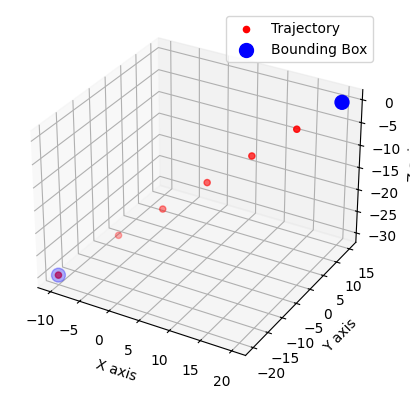

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example trajectory (x, y, z coordinates)
points = np.array([
    [-10, -20, -30],
    [-5, -10, -25],
    [0, -5, -20],
    [5, 0, -15],
    [10, 5, -10],
    [15, 10, -5],
    [20, 15, 0]
])

# Extract the bounding box dimensions
x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()
z_min, z_max = points[:, 2].min(), points[:, 2].max()

# Bounding box dimensions
width = x_max - x_min
height = y_max - y_min
depth = z_max - z_min

# Aspect ratio (width/height or height/depth, depending on context)
aspect_ratio_xy = width / height if height != 0 else 0
aspect_ratio_yz = height / depth if depth != 0 else 0

# Output the bounding box features
print(f"Bounding Box Dimensions: ")
print(f"Width: {width}")
print(f"Height: {height}")
print(f"Depth: {depth}")
print(f"Aspect Ratio (XY): {aspect_ratio_xy}")
print(f"Aspect Ratio (YZ): {aspect_ratio_yz}")

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='r', label='Trajectory')

# Plot bounding box (min-max values)
ax.scatter([x_min, x_max], [y_min, y_max], [z_min, z_max], color='b', label='Bounding Box', s=100)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.legend()
plt.show()
